In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Notes
This is a slightly tuned version of @nogawanogawa 's work and I have also converted his messages to english here you can find his notebook here https://www.kaggle.com/code/tsunotsuno/updated-debertav3-lgbm-with-spell-autocorrect 
@CODY_NULL translated and added it: https://www.kaggle.com/code/cody11null/tuned-debertav3-lgbm-autocorrect

Thank them for their efforts and please give them some support.

In this notebook a combonation of Deberta and LGBM is used, pyspellchecker is also used in order to correct some of the spelling mistakes that are discussed in the discussions tab
[Discussion Link](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion/428941).
[my previous notebook](https://www.kaggle.com/code/tsunotsuno/debertav3-lgbm-with-feature-engineering)
[Discussion Link](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion/428941).

The primary goal of this notebook is to enhance the overall score by honing in on the issue of "misspellings."


## Main Concept 

The Transformers model I'm currently utilizing, Deberta, is pretrained on "correct sentences." However, if I were to train and input it with sentences containing misspellings, Deberta's ability to understand meaning might be compromised.

From a human evaluator's perspective, detecting misspellings would prompt deductions in scores. After discreetly rectifying the misspelled words, I'd proceed to evaluate other textual facets. If we assume the scoring process aligns with this approach, it's conceivable that tallying and **correcting** misspellings before feeding text into Deberta could enable the model to aptly capture features beyond just misspellings.

In this notebook, I will embark on the journey of auto-correcting misspelled words before inputting them into Deberta. The aim is to evaluate the model's performance by distinctly isolating misspellings from other aspects.


### Feature Engineering

I intend to largely retain the same features as before:

- Text Length
- Length Ratio
- Word Overlap
- N-grams Co-occurrence
  - Count
  - Ratio
- Quotes Overlap
- Grammar Check
  - Spelling: pyspellchecker

### Model Architecture

I plan to construct a model with the architecture depicted in the following diagram. For the input to Deberta (`text`), I will pre-process by correcting any misspellings. In other aspects of feature engineering, I will utilize the `text` as is.


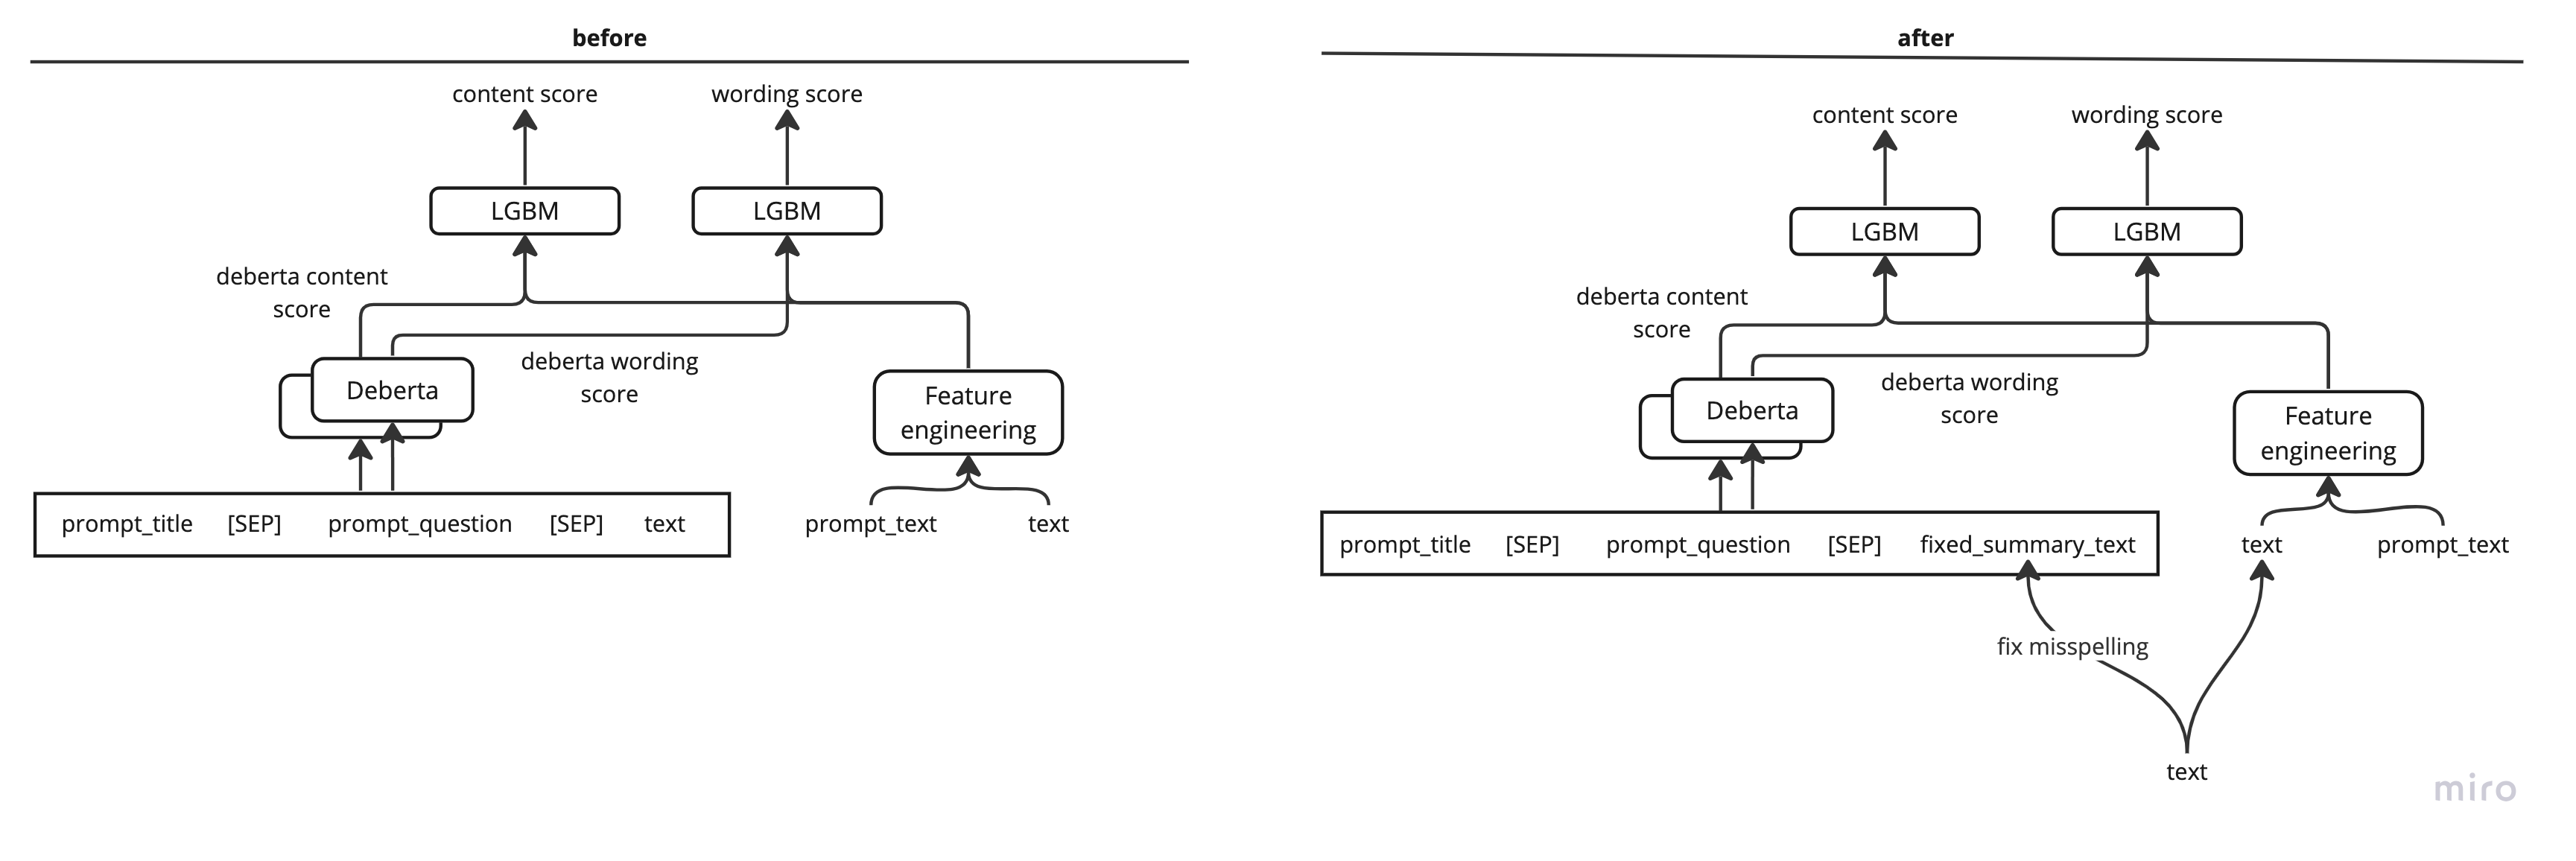

### References

- https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion/428941

### My previous notebooks

- https://www.kaggle.com/code/tsunotsuno/debertav3-baseline-content-and-wording-models
- https://www.kaggle.com/code/tsunotsuno/debertav3-w-prompt-title-question-fields
- https://www.kaggle.com/code/tsunotsuno/debertav3-with-llama2-example
- https://www.kaggle.com/code/tsunotsuno/debertav3-lgbm-with-feature-engineering


In [3]:
# !pip install lightgbm




In [4]:
from typing import List
import numpy as np
import pandas as pd
import warnings
import logging
import os
import shutil
import json
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset,load_dataset, load_from_disk
from transformers import TrainingArguments, Trainer
from datasets import load_metric, disable_progress_bar
from sklearn.metrics import mean_squared_error
import torch
from sklearn.model_selection import KFold, GroupKFold
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
import spacy
import re
from autocorrect import Speller
from spellchecker import SpellChecker
import lightgbm as lgb

warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
disable_progress_bar()
tqdm.pandas()

[2023-09-04 15:07:19,997] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [5]:
# Random seed function
# 随机种子函数

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed=42)

In [6]:
# Set configuration
# 设置配置类

class CFG:
    model_name='microsoft/deberta-v3-base'
    learning_rate=1.5e-5
    weight_decay=0.02 # Regularization 防止过拟合
    hidden_dropout_prob=0.007 # Dropout setting 随机失活的概率
    attention_probs_dropout_prob=0.007
    num_train_epochs=4
    n_splits=4
    batch_size=12
    random_seed=42
    save_steps=200 
    max_length=512 # Max length of imput 限制输入序列的长度

## Dataload

In [7]:
DATA_DIR = "../data/raw/"

prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")

## Preprocess

[Using features]

- Text Length
- Length Ratio
- Word Overlap
- N-grams Co-occurrence
  - count
  - ratio
- Quotes Overlap
- Grammar Check
  - spelling: pyspellchecker


In [8]:
# class for data preprocessing
# 用于数据预处理的类

class Preprocessor:
    def __init__(self, model_name: str,) -> None:
        self.tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/input/{model_name}") # 从预训练模型导入tokenizer
        self.twd = TreebankWordDetokenizer() # 用于将分词后的文本组合成完整句子
        self.STOP_WORDS = set(stopwords.words('english')) # 用于存储英语文本的停用词集合
        
        self.spacy_ner_model = spacy.load('en_core_web_sm',) # 用于存储英语文本的停用词集合
        self.speller = Speller(lang='en') # 用于实例化拼写纠错器
        self.spellchecker = SpellChecker() # 用于实例化拼写检查器
        
    def word_overlap_count(self, row): # 用于计算两个文本序列中重叠的词语数量，可以选择是否考虑停用词
        """ intersection(prompt_text, text) """        
        def check_is_stop_word(word):
            return word in self.STOP_WORDS
        
        prompt_words = row['prompt_tokens']
        summary_words = row['summary_tokens']
        if self.STOP_WORDS: # 检查是否在停用词集合里
            prompt_words = list(filter(check_is_stop_word, prompt_words))
            summary_words = list(filter(check_is_stop_word, summary_words))
        return len(set(prompt_words).intersection(set(summary_words)))
            
    def ngrams(self, token, n): # 返回一个包含所有 n-gram 字符串的列表
        # Use the zip function to help us generate n-grams
        # Concatentate the tokens into ngrams and return
        ngrams = zip(*[token[i:] for i in range(n)])
        return [" ".join(ngram) for ngram in ngrams]

    def ngram_co_occurrence(self, row, n: int) -> int: # 用于计算原始文本和摘要文本中 n-gram 共现的数量
        # Tokenize the original text and summary into words
        original_tokens = row['prompt_tokens']
        summary_tokens = row['summary_tokens']

        # Generate n-grams for the original text and summary
        original_ngrams = set(self.ngrams(original_tokens, n))
        summary_ngrams = set(self.ngrams(summary_tokens, n))

        # Calculate the number of common n-grams
        common_ngrams = original_ngrams.intersection(summary_ngrams)
        return len(common_ngrams)
    
    def ner_overlap_count(self, row, mode:str): # 用于计算两个文本中命名实体（Named Entity）的交集数量。
        model = self.spacy_ner_model
        def clean_ners(ner_list):
            return set([(ner[0].lower(), ner[1]) for ner in ner_list])
        prompt = model(row['prompt_text'])
        summary = model(row['text'])

        if "spacy" in str(model):
            prompt_ner = set([(token.text, token.label_) for token in prompt.ents])
            summary_ner = set([(token.text, token.label_) for token in summary.ents])
        elif "stanza" in str(model):
            prompt_ner = set([(token.text, token.type) for token in prompt.ents])
            summary_ner = set([(token.text, token.type) for token in summary.ents])
        else:
            raise Exception("Model not supported")

        prompt_ner = clean_ners(prompt_ner)
        summary_ner = clean_ners(summary_ner)

        intersecting_ners = prompt_ner.intersection(summary_ner)
        
        ner_dict = dict(Counter([ner[1] for ner in intersecting_ners]))
        
        if mode == "train":
            return ner_dict
        elif mode == "test":
            return {key: ner_dict.get(key) for key in self.ner_keys}

    
    def quotes_count(self, row): # 统计原始文本中出现在摘要文本中的引号的数量。这可以用来衡量原始文本和摘要文本之间的相似性
        summary = row['text']
        text = row['prompt_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary) # 获取摘要文本中提取出所有双引号之间的内容
        if len(quotes_from_summary)>0: # 检查提取的引号内容，检查是否在原始文本中
            return [quote in text for quote in quotes_from_summary].count(True)
        else:
            return 0

    def spelling(self, text): # 用于检测文本中的拼写错误数量    
        wordlist=text.split()
        # 使用 PySpellChecker 库的 spellchecker 实例，检查单词列表中未知的（即不在词典中的）拼写错误的数量。
        # unknown 方法返回未知的拼写错误单词列表，通过计算其长度来获得错误数量。
        amount_miss = len(list(self.spellchecker.unknown(wordlist))) 

        return amount_miss
    
    def add_spelling_dictionary(self, tokens: List[str]) -> List[str]: # 将一个词汇列表添加到拼写检查的词典中，以便拼写检查器能够更准确地检查文本中的拼写错误。
        """dictionary update for pyspell checker and autocorrect"""
        self.spellchecker.word_frequency.load_words(tokens) 
        self.speller.nlp_data.update({token:1000 for token in tokens})
    
    def run(self, 
            prompts: pd.DataFrame,
            summaries:pd.DataFrame,
            mode:str
        ) -> pd.DataFrame:
        
        # before merge preprocess
        prompts["prompt_length"] = prompts["prompt_text"].apply(
            lambda x: len(word_tokenize(x))
        )
        prompts["prompt_tokens"] = prompts["prompt_text"].apply(
            lambda x: word_tokenize(x)
        )

        summaries["summary_length"] = summaries["text"].apply(
            lambda x: len(word_tokenize(x))
        )
        summaries["summary_tokens"] = summaries["text"].apply(
            lambda x: word_tokenize(x)
        )
        
        # Add prompt tokens into spelling checker dictionary
        prompts["prompt_tokens"].apply(
            lambda x: self.add_spelling_dictionary(x)
        )
        
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        # fix misspelling
        summaries["fixed_summary_text"] = summaries["text"].progress_apply(
            lambda x: self.speller(x)
        )
        
        # count misspelling
        summaries["splling_err_num"] = summaries["text"].progress_apply(self.spelling)
        
        # merge prompts and summaries
        input_df = summaries.merge(prompts, how="left", on="prompt_id")

        # after merge preprocess
        input_df['length_ratio'] = input_df['summary_length'] / input_df['prompt_length']
        
        input_df['word_overlap_count'] = input_df.progress_apply(self.word_overlap_count, axis=1)
        input_df['bigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence,args=(2,), axis=1 
        )
        input_df['bigram_overlap_ratio'] = input_df['bigram_overlap_count'] / (input_df['summary_length'] - 1)
        
        input_df['trigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence, args=(3,), axis=1
        )
        input_df['trigram_overlap_ratio'] = input_df['trigram_overlap_count'] / (input_df['summary_length'] - 2)
        
        input_df['quotes_count'] = input_df.progress_apply(self.quotes_count, axis=1)
        
        return input_df.drop(columns=["summary_tokens", "prompt_tokens"])
    
# preprocessor = Preprocessor(model_name=CFG.model_name)

In [9]:
# train = preprocessor.run(prompts_train, summaries_train, mode="train")
# test = preprocessor.run(prompts_test, summaries_test, mode="test")


train = pd.read_csv(DATA_DIR + "train_folds_processed.csv")
test = pd.read_csv(DATA_DIR + "test.csv")

train.head()

,student_id,prompt_id,text,content,wording,fold,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,3,64,The third wave was an experimental see how peo...,5,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,660,0.096970,14,4,0.063492,0,0.000000,0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,2,54,They would rub it up with soda to make the sme...,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",1076,0.050186,18,22,0.415094,10,0.192308,0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,1,269,"In Egypt, there were many occupations and soci...",32,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,625,0.430400,22,52,0.194030,23,0.086142,2
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,1,28,The highest class was Pharaohs these people we...,5,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,625,0.044800,6,6,0.222222,5,0.192308,0
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,3,232,The Third Wave developed rapidly because the ...,29,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,660,0.351515,23,27,0.116883,5,0.021739,4


In [10]:
# train.to_csv("train.csv", index=False)
# test.to_csv("test.csv", index=False)

In [11]:
train.head(2)

,student_id,prompt_id,text,content,wording,fold,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,3,64,The third wave was an experimental see how peo...,5,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,660,0.096970,14,4,0.063492,0,0.000000,0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,2,54,They would rub it up with soda to make the sme...,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",1076,0.050186,18,22,0.415094,10,0.192308,0


## Model Function Definition

In [12]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

def compute_mcrmse(eval_pred):
    """
    Calculates mean columnwise root mean squared error
    https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview/evaluation
    """
    preds, labels = eval_pred

    col_rmse = np.sqrt(np.mean((preds - labels) ** 2, axis=0))
    mcrmse = np.mean(col_rmse)

    return {
        "content_rmse": col_rmse[0],
        "wording_rmse": col_rmse[1],
        "mcrmse": mcrmse,
    }

def compt_score(content_true, content_pred, wording_true, wording_pred):
    content_score = mean_squared_error(content_true, content_pred)**(1/2)
    wording_score = mean_squared_error(wording_true, wording_pred)**(1/2)
    
    return (content_score + wording_score)/2

## Deberta Regressor

In [13]:
class ContentScoreRegressor:
    def __init__(self, 
                model_name: str,
                model_dir: str,
                target: str,
                hidden_dropout_prob: float,
                attention_probs_dropout_prob: float,
                max_length: int,
                ):
        self.inputs = ["prompt_text", "prompt_title", "prompt_question", "fixed_summary_text"]
        self.input_col = "input"
        
        self.text_cols = [self.input_col] 
        self.target = target
        self.target_cols = [target]

        self.model_name = model_name
        self.model_dir = model_dir
        self.max_length = max_length
        
        self.tokenizer = AutoTokenizer.from_pretrained(f"{model_name}")
        self.model_config = AutoConfig.from_pretrained(f"{model_name}")
        
        self.model_config.update({
            "hidden_dropout_prob": hidden_dropout_prob,
            "attention_probs_dropout_prob": attention_probs_dropout_prob,
            "num_labels": 1,
            "problem_type": "regression",
        })
        
        seed_everything(seed=42)

        self.data_collator = DataCollatorWithPadding(
            tokenizer=self.tokenizer
        )


    def tokenize_function(self, examples: pd.DataFrame):
        labels = [examples[self.target]]
        tokenized = self.tokenizer(examples[self.input_col],
                         padding=False,
                         truncation=True,
                         max_length=self.max_length)
        return {
            **tokenized,
            "labels": labels,
        }
    
    def tokenize_function_test(self, examples: pd.DataFrame):
        tokenized = self.tokenizer(examples[self.input_col],
                         padding=False,
                         truncation=True,
                         max_length=self.max_length)
        return tokenized
        
    def train(self, 
            fold: int,
            train_df: pd.DataFrame,
            valid_df: pd.DataFrame,
            batch_size: int,
            learning_rate: float,
            weight_decay: float,
            num_train_epochs: float,
            save_steps: int,
        ) -> None:
        """fine-tuning"""
        
        sep = self.tokenizer.sep_token
#         train_df[self.input_col] = (
#                     train_df["prompt_title"] + sep 
#                     + train_df["prompt_question"] + sep 
#                     + train_df["fixed_summary_text"]
#                   )

#         valid_df[self.input_col] = (
#                     valid_df["prompt_title"] + sep 
#                     + valid_df["prompt_question"] + sep 
#                     + valid_df["fixed_summary_text"]
#                   )

        train_df[self.input_col] = (
                    train_df["fixed_summary_text"]
                  )

        valid_df[self.input_col] = (
                    valid_df["fixed_summary_text"]
                  )



        
        train_df = train_df[[self.input_col] + self.target_cols]
        valid_df = valid_df[[self.input_col] + self.target_cols]
        
        model_content = AutoModelForSequenceClassification.from_pretrained(
            f"{self.model_name}", 
            config=self.model_config
        )

        train_dataset = Dataset.from_pandas(train_df, preserve_index=False) 
        val_dataset = Dataset.from_pandas(valid_df, preserve_index=False) 
    
        train_tokenized_datasets = train_dataset.map(self.tokenize_function, batched=False)
        val_tokenized_datasets = val_dataset.map(self.tokenize_function, batched=False)

        # eg. "bert/fold_0/"
        model_fold_dir = os.path.join(self.model_dir, str(fold)) 
        
        training_args = TrainingArguments(
            output_dir=model_fold_dir,
            load_best_model_at_end=True, # select best model
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=8,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
            report_to='none',
            greater_is_better=False,
            save_strategy="steps",
            evaluation_strategy="steps",
            eval_steps=save_steps,
            save_steps=save_steps,
            metric_for_best_model="rmse",
            save_total_limit=1
        )

        trainer = Trainer(
            model=model_content,
            args=training_args,
            train_dataset=train_tokenized_datasets,
            eval_dataset=val_tokenized_datasets,
            tokenizer=self.tokenizer,
            compute_metrics=compute_metrics,
            data_collator=self.data_collator
        )

        trainer.train()
        
        model_content.save_pretrained(self.model_dir)
        self.tokenizer.save_pretrained(self.model_dir)

        
    def predict(self, 
                test_df: pd.DataFrame,
                fold: int,
               ):
        """predict content score"""
        
        sep = self.tokenizer.sep_token
        in_text = (
                    test_df["prompt_title"] + sep 
                    + test_df["prompt_question"] + sep 
                    + test_df["fixed_summary_text"]
                  )
        test_df[self.input_col] = in_text

        test_ = test_df[[self.input_col]]
    
        test_dataset = Dataset.from_pandas(test_, preserve_index=False) 
        test_tokenized_dataset = test_dataset.map(self.tokenize_function_test, batched=False)

        model_content = AutoModelForSequenceClassification.from_pretrained(f"{self.model_dir}")
        model_content.eval()
        
        # e.g. "bert/fold_0/"
        model_fold_dir = os.path.join(self.model_dir, str(fold)) 

        test_args = TrainingArguments(
            output_dir=model_fold_dir,
            do_train = False,
            do_predict = True,
            per_device_eval_batch_size = 4,   
            dataloader_drop_last = False,
        )

        # init trainer
        infer_content = Trainer(
                      model = model_content, 
                      tokenizer=self.tokenizer,
                      data_collator=self.data_collator,
                      args = test_args)

        preds = infer_content.predict(test_tokenized_dataset)[0]

        return preds

In [14]:
def train_by_fold(
        train_df: pd.DataFrame,
        model_name: str,
        target:str,
        save_each_model: bool,
        n_splits: int,
        batch_size: int,
        learning_rate: int,
        hidden_dropout_prob: float,
        attention_probs_dropout_prob: float,
        weight_decay: float,
        num_train_epochs: int,
        save_steps: int,
        max_length:int
    ):

#     # delete old model files
#     if os.path.exists(model_name):
#         shutil.rmtree(model_name)
    
#     os.mkdir(model_name)
        
    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        train_data = train_df[train_df["fold"] != fold]
        valid_data = train_df[train_df["fold"] == fold]
        
        if save_each_model == True:
            model_dir =  f"{target}/{model_name}/fold_{fold}"
        else: 
            model_dir =  f"{model_name}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir, 
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        csr.train(
            fold=fold,
            train_df=train_data,
            valid_df=valid_data, 
            batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            num_train_epochs=num_train_epochs,
            save_steps=save_steps,
        )

def validate(
    train_df: pd.DataFrame,
    target:str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length : int
    ) -> pd.DataFrame:
    """predict oof data"""
    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        valid_data = train_df[train_df["fold"] == fold]
        
        if save_each_model == True:
            model_dir =  f"{target}/{model_name}/fold_{fold}"
        else: 
            model_dir =  f"{model_name}/fold_{fold}"
        
        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir,
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        pred = csr.predict(
            test_df=valid_data, 
            fold=fold
        )
        
        train_df.loc[valid_data.index, f"{target}_pred"] = pred

    return train_df
    
def predict(
    test_df: pd.DataFrame,
    target:str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length : int
    ):
    """predict using mean folds"""

    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")
        
        if save_each_model == True:
            model_dir =  f"{target}/{model_name}/fold_{fold}"
        else: 
            model_dir =  f"{model_name}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir = model_dir, 
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        pred = csr.predict(
            test_df=test_df, 
            fold=fold
        )
        
        test_df[f"{target}_pred_{fold}"] = pred
    
    test_df[f"{target}"] = test_df[[f"{target}_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)

    return test_df

In [16]:
for target in ["content", "wording"]:
#     train_by_fold(
#         train,
#         model_name=CFG.model_name,
#         save_each_model=False,
#         target=target,
#         learning_rate=CFG.learning_rate,
#         hidden_dropout_prob=CFG.hidden_dropout_prob,
#         attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
#         weight_decay=CFG.weight_decay,
#         num_train_epochs=CFG.num_train_epochs,
#         n_splits=CFG.n_splits,
#         batch_size=CFG.batch_size,
#         save_steps=CFG.save_steps,
#         max_length=CFG.max_length
#     )
    
    
    train = validate(
        train,
        target=target,
        save_each_model=False,
        model_name=CFG.model_name,
        hidden_dropout_prob=CFG.hidden_dropout_prob,
        attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
        max_length=CFG.max_length
    )

    rmse = mean_squared_error(train[target], train[f"{target}_pred"], squared=False)
    print(f"cv {target} rmse: {rmse}")

    test = predict(
        test,
        target=target,
        save_each_model=False,
        model_name=CFG.model_name,
        hidden_dropout_prob=CFG.hidden_dropout_prob,
        attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
        max_length=CFG.max_length
    )

fold 0:


OSError: microsoft/deberta-v3-base does not appear to have a file named config.json. Checkout 'https://huggingface.co/microsoft/deberta-v3-base/None' for available files.

In [17]:
train.head()

,student_id,prompt_id,text,content,wording,fold,summary_length,fixed_summary_text,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,3,64,The third wave was an experimental see how peo...,5,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,660,0.096970,14,4,0.063492,0,0.000000,0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,2,54,They would rub it up with soda to make the sme...,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",1076,0.050186,18,22,0.415094,10,0.192308,0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,1,269,"In Egypt, there were many occupations and soci...",32,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,625,0.430400,22,52,0.194030,23,0.086142,2
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,1,28,The highest class was Pharaohs these people we...,5,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,625,0.044800,6,6,0.222222,5,0.192308,0
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,3,232,The Third Wave developed rapidly because the ...,29,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,660,0.351515,23,27,0.116883,5,0.021739,4


## LGBM model

In [ ]:
targets = ["content", "wording"]

drop_columns = ["fold", "student_id", "prompt_id", "text", "fixed_summary_text",
                "prompt_question", "prompt_title", 
                "prompt_text"
               ] + targets

In [ ]:
model_dict = {}

for target in targets:
    models = []
    
    for fold in range(CFG.n_splits):

        X_train_cv = train[train["fold"] != fold].drop(columns=drop_columns)
        y_train_cv = train[train["fold"] != fold][target]

        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv = train[train["fold"] == fold][target]

        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

        params = {
            'boosting_type': 'gbdt',
            'random_state': 42,
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.05,
        }

        evaluation_results = {}
        model = lgb.train(params,
                          num_boost_round=10000,
                            #categorical_feature = categorical_features,
                          valid_names=['train', 'valid'],
                          train_set=dtrain,
                          valid_sets=dval,
                          callbacks=[
                              lgb.early_stopping(stopping_rounds=30, verbose=True),
                               lgb.log_evaluation(100),
                              lgb.callback.record_evaluation(evaluation_results)
                            ],
                          )
        models.append(model)
    
    model_dict[target] = models

## CV Score

In [ ]:
# cv
rmses = []

for target in targets:
    models = model_dict[target]

    preds = []
    trues = []
    
    for fold, model in enumerate(models):
        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv = train[train["fold"] == fold][target]

        pred = model.predict(X_eval_cv)

        trues.extend(y_eval_cv)
        preds.extend(pred)
        
    rmse = np.sqrt(mean_squared_error(trues, preds))
    print(f"{target}_rmse : {rmse}")
    rmses = rmses + [rmse]

print(f"mcrmse : {sum(rmses) / len(rmses)}")

## Predict

In [ ]:
drop_columns = [
                #"fold", 
                "student_id", "prompt_id", "text", "fixed_summary_text",
                "prompt_question", "prompt_title", 
                "prompt_text",
                "input"
               ] + [
                f"content_pred_{i}" for i in range(CFG.n_splits)
                ] + [
                f"wording_pred_{i}" for i in range(CFG.n_splits)
                ]

In [ ]:
pred_dict = {}
for target in targets:
    models = model_dict[target]
    preds = []

    for fold, model in enumerate(models):
        X_eval_cv = test.drop(columns=drop_columns)

        pred = model.predict(X_eval_cv)
        preds.append(pred)
    
    pred_dict[target] = preds

In [ ]:
for target in targets:
    preds = pred_dict[target]
    for i, pred in enumerate(preds):
        test[f"{target}_pred_{i}"] = pred

    test[target] = test[[f"{target}_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)

In [ ]:
test

## Create Submission file

In [ ]:
sample_submission

In [ ]:
test[["student_id", "content", "wording"]].to_csv("submission.csv", index=False)

## Summary

CV result is like this.

| | content rmse |wording rmse | mcrmse | LB| |
| -- | -- | -- | -- | -- | -- |
|baseline| 0.494 | 0.630 | 0.562 | 0.509 | [link](https://www.kaggle.com/code/tsunotsuno/debertav3-baseline-content-and-wording-models)|
| use title and question field | 0.476| 0.619 | 0.548 | 0.508 | [link](https://www.kaggle.com/code/tsunotsuno/debertav3-w-prompt-title-question-fields) |
| Debertav3 + LGBM | 0.451 | 0.591 | 0.521 | 0.461 | [link](https://www.kaggle.com/code/tsunotsuno/debertav3-lgbm-with-feature-engineering) |
| Debertav3 + LGBM with spell autocorrect | 0.448 | 0.581 | 0.514 | 0.459 |nogawanogawa's original code
| Debertav3 + LGBM with spell autocorrect and tuning | 0.447 | 0.575 | 0.511 | 0.453 | this notebook |

The CV values improved slightly, and the LB value is improved.